# Deep learning volatility

In [1]:
%config Completer.use_jedi=False

import os
os.chdir("Data")
# import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import csv
import pandas as pd
import scipy

In [153]:
# df = np.loadtxt("parameters_impliedVols.txt")
df70 = np.loadtxt('impliedVols_server70_market.txt')
df70_min = np.loadtxt('impliedVols_server70_market_min.txt')
df62 = np.loadtxt('impliedVols_server62_market.txt')
df = np.concatenate((df62, df70, df70_min))
print(df.shape)
# np.savetxt("parameters_impliedVols.txt", df, fmt="%.4f")
xx=df[:,:6]
yy=df[:,6:]
print(xx.shape, yy.shape)
# maturities = np.array([0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 1.5, 2.0])
# strikes = np.array([95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105])
maturities = np.array([0.06, 0.15, 0.31, 0.56])
strikes = np.array([5.25, 5.50, 5.75, 6.00, 6.25])
strike_dim = len(strikes)
maturities_dim = len(maturities)

xx[0], yy[0][:11]


(7000, 26)
(7000, 6) (7000, 20)


(array([0.6655, 0.6663, 0.741 , 0.7981, 0.0079, 0.2456]),
 array([0.4719, 0.4437, 0.4164, 0.3902, 0.3658, 0.4811, 0.4575, 0.4349,
        0.4129, 0.3913, 0.4841]))

In [154]:
#remove invalid paramters
invalid = np.where(yy == yy.min())[0]
xx = np.delete(xx, (invalid), axis=0)
yy = np.delete(yy, (invalid), axis=0)
xx.shape, yy.shape

((4840, 6), (4840, 20))

$$
\begin{aligned}
dS_t &= S_t\sqrt{V_t}dW_t,\\
dV_t &= \kappa(\theta-V_t)dt + \nu\sqrt{V_t}dB_t
\end{aligned}
$$

# Step 1: Data Generation


### **Inputs:** 
####  1. $\nu_{0}$ spot variance 
####  2. $\rho$ spot-vol correlation,
####  3. $\sigma$ vol of vol
####  4. $\theta$ long term vol
####  5. $\kappa$ speed of mean reversion 
    
    
### **Outputs:**
#### Implied volatility surface (11x8=88 points)

## Scaling:

### Model Parameters $\theta\to scale(\theta)\in[0,1]$
$$scale(\theta^i)=\frac{(\theta^i-\theta^i_{min})}{\theta^i_{max}-\theta^i_{min}},\quad i \in |\Theta|$$

### Implied volatilities
$$scale(\sigma_{BS}^{i,j})=\frac{\sigma_{BS}^{i,j}-\mathbb{E}[\sigma_{BS}^{i,j}]}{std(\sigma_{BS}^{i,j})},\quad i\in\text{Maturities},\; j\in \text{Strikes}$$

In [155]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scale_ss = StandardScaler()
y_train_transform = scale_ss.fit_transform(y_train)
y_test_transform = scale_ss.transform(y_test)

scale_mm = MinMaxScaler()
x_train_transform = scale_mm.fit_transform(X_train)
x_test_transform = scale_mm.transform(X_test)

$\alpha\in[0.005, 0.2],\; \lambda\in[0.1, 2.0],\; a\in[0.1, 1.0],\; b\in[0.01, 1.0],\; c\in[0.0001, 0.01],\; Z0\in[0.01, 0.3]$

In [156]:
# ub=[0.7,   2.0,  1.0,  1.0,  0.01,   0.3]
# lb=[0.505, 0.1,  0.1,  0.01, 0.0001, 0.01]

# def myscale(x):
#     res=np.zeros(6)
#     for i in range(6):
#         res[i]=(x[i] - lb[i])/ (ub[i] - lb[i])
#     return res

# def myinverse(x):
#     res=np.zeros(6)
#     for i in range(6):
#         res[i] = lb[i] + (ub[i] - lb[i])*x[i]
#     return res

# def myscale(x):
#     res=np.zeros(6)
#     for i in range(6):
#         res[i]=(x[i] - (ub[i] + lb[i])*0.5) * 2 / (ub[i] - lb[i])
        
#     return res
# def myinverse(x):
#     res=np.zeros(6)
#     for i in range(6):
#         res[i]=x[i]*(ub[i] - lb[i]) *0.5 + (ub[i] + lb[i])*0.5
        
#     return res

In [157]:
# x_train_transform = np.array([myscale(x) for x in X_train])
# x_test_transform = np.array([myscale(x) for x in X_test])
x_test_transform.shape

(726, 6)

# Step 2. Create the Neural Network

In [158]:
import keras
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
keras.backend.set_floatx('float64')


input1 = keras.layers.Input(shape=(6,))
x1 = keras.layers.Dense(30,activation = 'elu')(input1)
x2=keras.layers.Dense(30,activation = 'elu')(x1) 
x3=keras.layers.Dense(30,activation = 'elu')(x2) 


x4=keras.layers.Dense(20,activation = 'linear')(x3)


modelGEN = keras.models.Model(inputs=input1, outputs=x4)
modelGEN.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_20 (Dense)             (None, 30)                210       
_________________________________________________________________
dense_21 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_22 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_23 (Dense)             (None, 20)                620       
Total params: 2,690
Trainable params: 2,690
Non-trainable params: 0
_________________________________________________________________


# Step 3. Fit the Neural Network (No need to run the code, parameters are stored on a .h5 file)

In [159]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
modelGEN.compile(loss = root_mean_squared_error, optimizer = "adam")



In [160]:
modelGEN.fit(x_train_transform, y_train_transform, 
             batch_size=32,
#              validation_split = 0.2,
             validation_data = (x_test_transform, y_test_transform),
             epochs = 100, verbose = True,shuffle=1)#,callbacks=[earlystop])

Epoch 1/100
129/129 [==============================] - 0s 2ms/step - loss: 0.7514 - val_loss: 0.4425
Epoch 2/100
129/129 [==============================] - 0s 1ms/step - loss: 0.3746 - val_loss: 0.2959
Epoch 3/100
129/129 [==============================] - 0s 1ms/step - loss: 0.2999 - val_loss: 0.2645
Epoch 4/100
129/129 [==============================] - 0s 1ms/step - loss: 0.2830 - val_loss: 0.2531
Epoch 5/100
129/129 [==============================] - 0s 1ms/step - loss: 0.2746 - val_loss: 0.2489
Epoch 6/100
129/129 [==============================] - 0s 1ms/step - loss: 0.2616 - val_loss: 0.2377
Epoch 7/100
129/129 [==============================] - 0s 1ms/step - loss: 0.2509 - val_loss: 0.2224
Epoch 8/100
129/129 [==============================] - 0s 1ms/step - loss: 0.2435 - val_loss: 0.2303
Epoch 9/100
129/129 [==============================] - 0s 1ms/step - loss: 0.2352 - val_loss: 0.2055
Epoch 10/100
129/129 [==============================] - 0s 1ms/step - loss: 0.2231 - val_lo

129/129 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0485
Epoch 82/100
129/129 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 0.0548
Epoch 83/100
129/129 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.0495
Epoch 84/100
129/129 [==============================] - 0s 1ms/step - loss: 0.0640 - val_loss: 0.0484
Epoch 85/100
129/129 [==============================] - 0s 1ms/step - loss: 0.0637 - val_loss: 0.0459
Epoch 86/100
129/129 [==============================] - 0s 1ms/step - loss: 0.0644 - val_loss: 0.0460
Epoch 87/100
129/129 [==============================] - 0s 1ms/step - loss: 0.0642 - val_loss: 0.0484
Epoch 88/100
129/129 [==============================] - 0s 1ms/step - loss: 0.0666 - val_loss: 0.0446
Epoch 89/100
129/129 [==============================] - 0s 1ms/step - loss: 0.0652 - val_loss: 0.0480
Epoch 90/100
129/129 [==============================] - 0s 1ms/step - loss: 0.0624 - val_loss: 

### Store/Load optimal NN parameteres

In [161]:
modelGEN.save_weights('HestonNNWeights.h5')

In [162]:
modelGEN.load_weights('HestonNNWeights.h5')

In [163]:
NNParameters=[]
for i in range(1,len(modelGEN.layers)):
    NNParameters.append(modelGEN.layers[i].get_weights())

# Step 4. Optimisation
### (Numpy Implementation of the Neural Network tends to be faster than Keras)

Here the *elu* function writes:
$$elu(x) = \begin{cases}e^{x}-1,\; x<0\\
x,\; x\geq 0.
\end{cases}$$

In [164]:
NumLayers=3
def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x
def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x
def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,NNParameters[i][0])+NNParameters[i][1]
def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(6)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=(np.dot(input1,NNParameters[i][0])+NNParameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, NNParameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
#     grad=np.einsum('ij,jk->ik',grad,NNParameters[i+1][0])
    grad=np.dot(grad,NNParameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

# Compute Implied vol relative errors on Test set

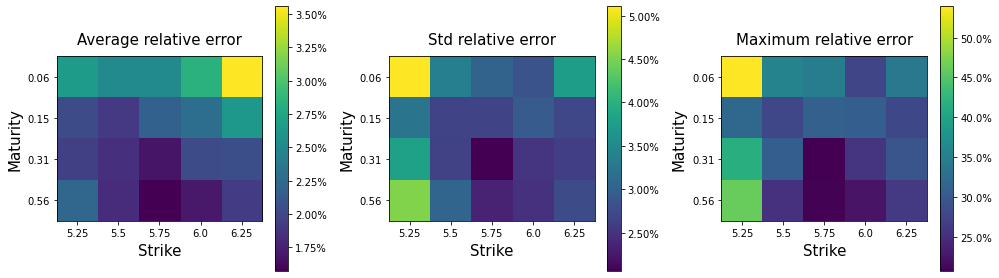

In [165]:
strikes_dim=len(strikes)
maturities_dim=len(maturities)
##### AVERAGE VALUES #######
X_sample = x_test_transform
y_sample = y_test

prediction=[scale.inverse_transform(modelGEN.predict(X_sample[i].reshape(1,6))[0]) for i in range(len(X_sample))]

plt.figure(1,figsize=(14,4))
ax=plt.subplot(1,3,1)
err = np.mean(100*np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Average relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())

ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,2)
err = 100*np.std(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Std relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)

ax=plt.subplot(1,3,3)
err = 100*np.max(np.abs((y_sample-prediction)/y_sample),axis = 0)
plt.title("Maximum relative error",fontsize=15,y=1.04)
plt.imshow(err.reshape(maturities_dim,strikes_dim))
plt.colorbar(format=mtick.PercentFormatter())
ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
ax.set_xticklabels(strikes)
ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
ax.set_yticklabels(maturities)
plt.xlabel("Strike",fontsize=15,labelpad=5)
plt.ylabel("Maturity",fontsize=15,labelpad=5)
plt.tight_layout()
# plt.savefig('HestonNNErrors.png', dpi=300)
plt.show()


# Plot sample Smiles

[0.532  0.867  0.2646 0.8537 0.0038 0.1358]


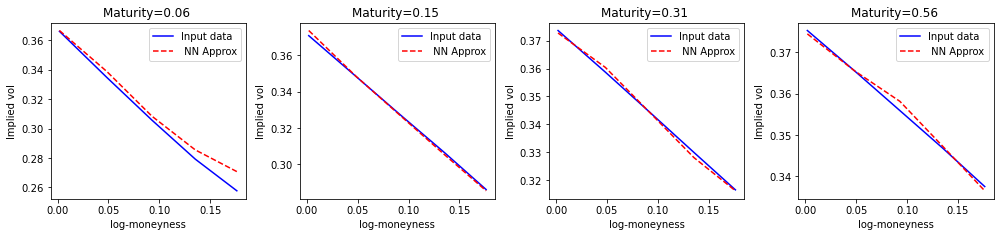

[0.5399 1.2551 0.4909 0.7544 0.0075 0.219 ]


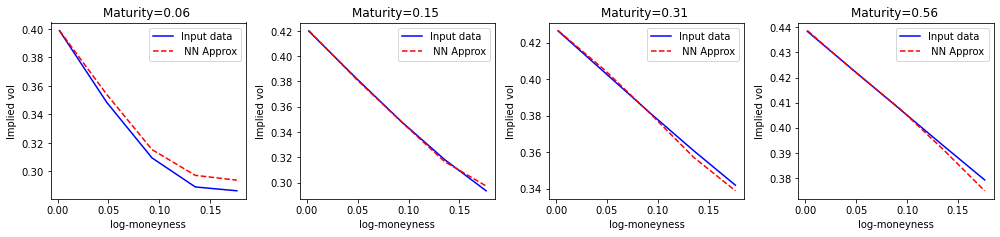

[5.299e-01 4.510e-01 3.782e-01 9.189e-01 6.000e-04 2.780e-01]


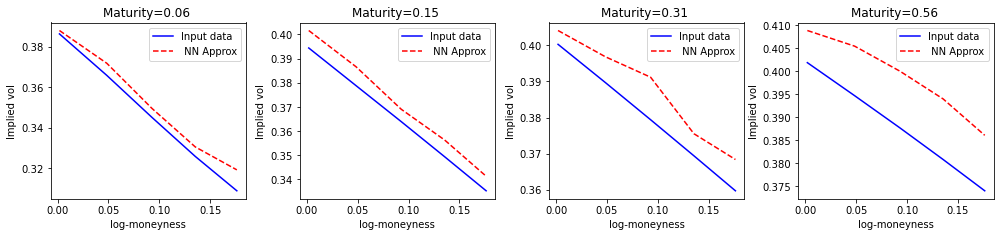

[0.516  1.7009 0.4509 0.739  0.0068 0.2479]


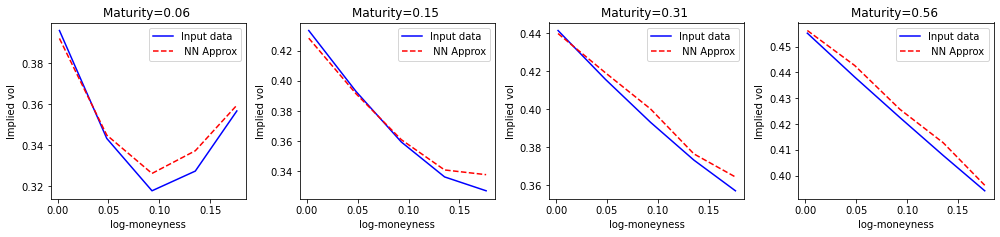

[0.6031 1.2266 0.6796 0.1186 0.0031 0.244 ]


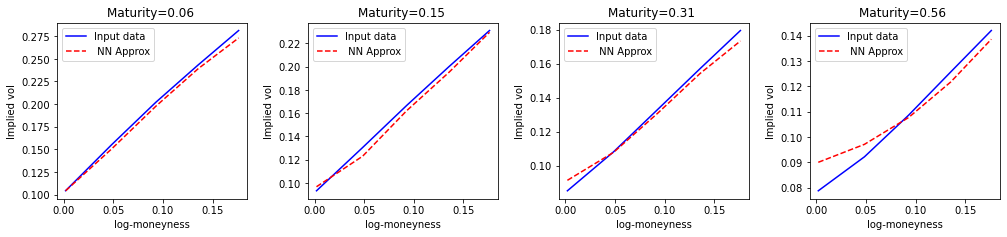

[0.6149 0.9241 0.9925 0.9649 0.0011 0.2839]


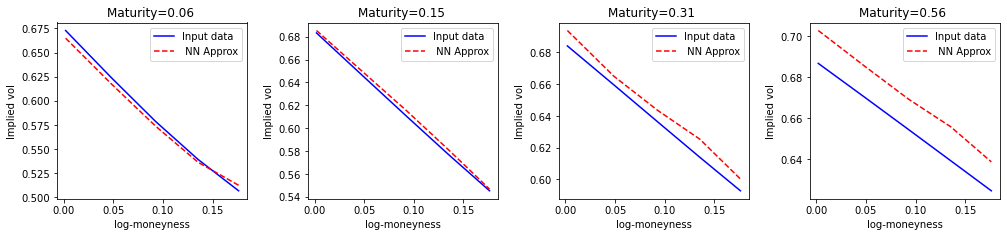

[0.5052 1.036  0.9645 0.9976 0.0094 0.0492]


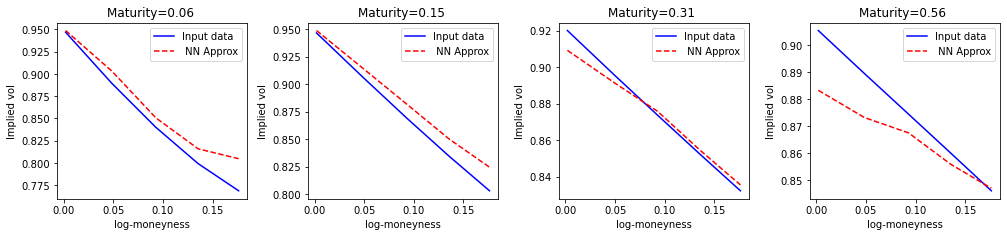

[0.5772 0.5233 0.108  0.8527 0.002  0.1439]


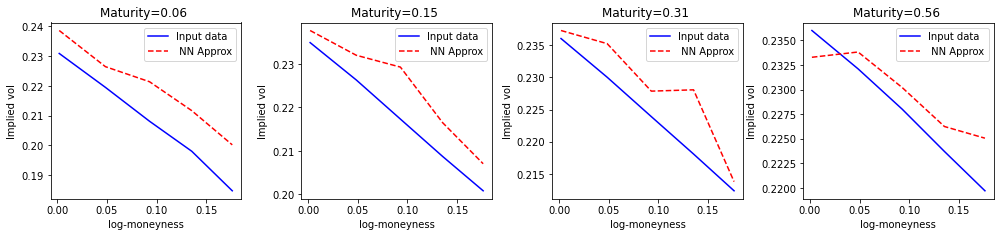

[0.586  0.4318 0.4029 0.954  0.0097 0.0902]


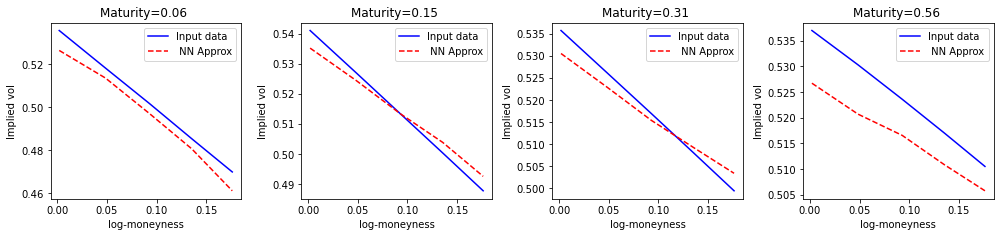

[0.6848 0.3283 0.2103 0.8279 0.0019 0.1073]


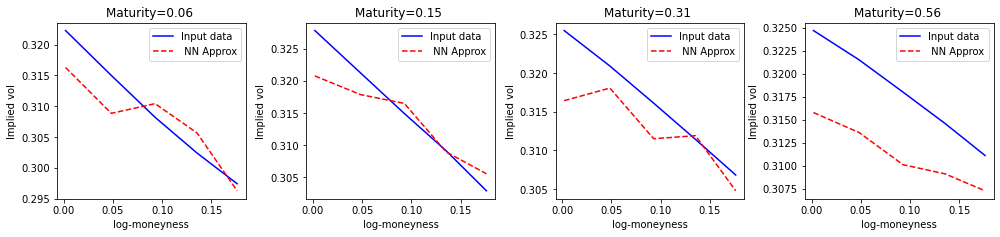

[0.5568 1.9326 0.6919 0.6682 0.0095 0.2465]


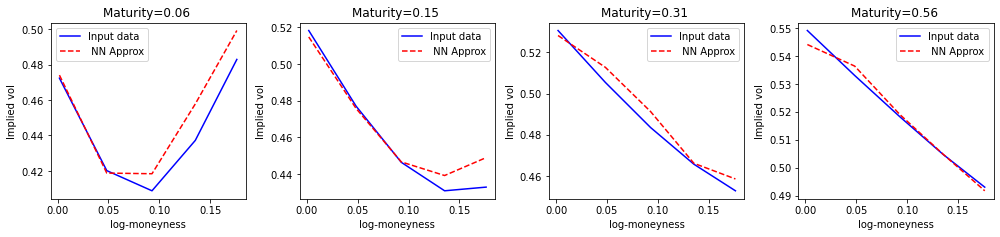

[0.6008 1.765  0.235  0.8773 0.0027 0.1545]


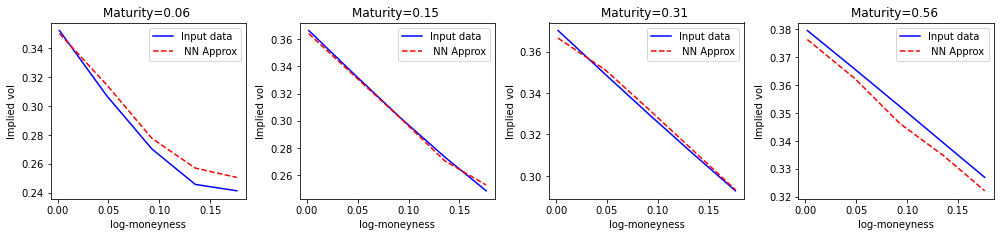

[0.5484 1.1554 0.3914 0.4694 0.0067 0.0271]


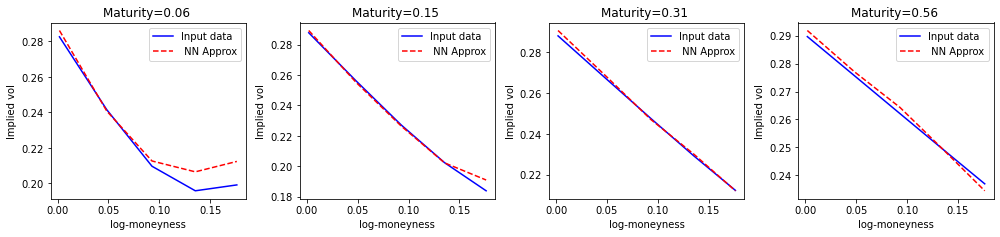

[0.6174 0.6029 0.9589 0.282  0.0067 0.0363]


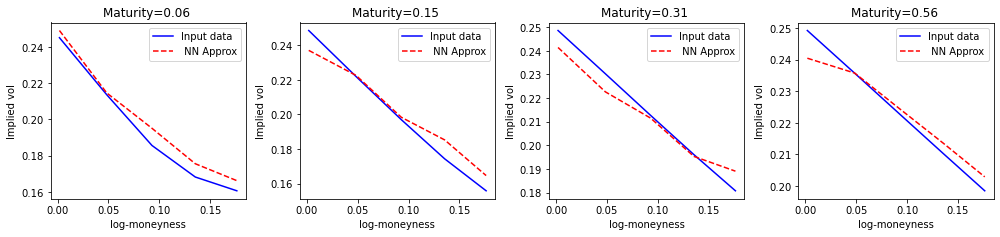

[0.6455 1.6335 0.9735 0.174  0.0044 0.0884]


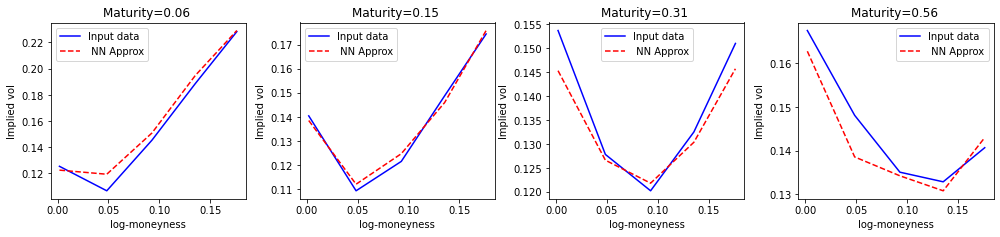

[0.5577 0.3038 0.5249 0.6948 0.0093 0.2346]


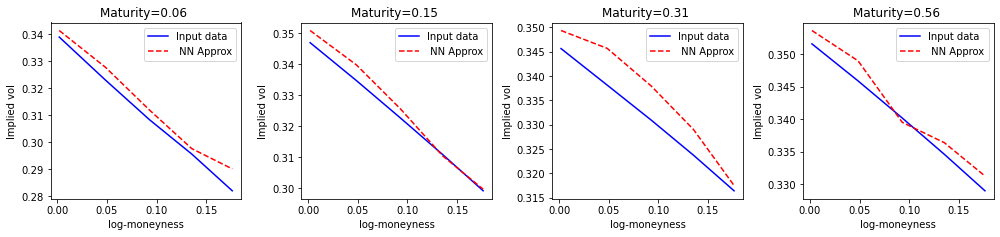

[0.5545 0.3398 0.7719 0.6801 0.0049 0.2117]


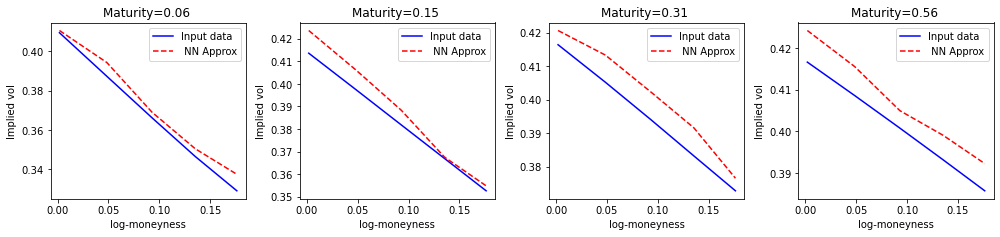

[6.7550e-01 1.3965e+00 9.1660e-01 8.2910e-01 2.0000e-04 1.4010e-01]


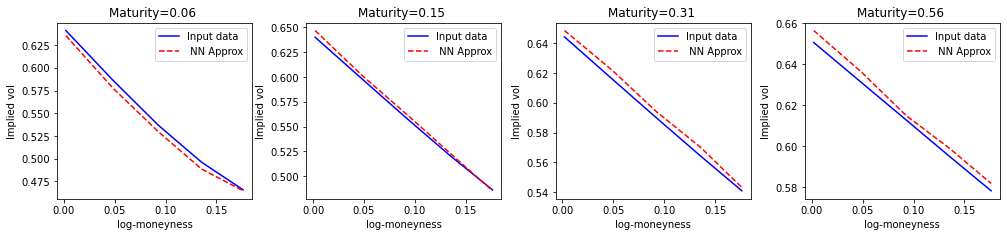

[0.5141 1.6996 0.8134 0.1048 0.0096 0.0645]


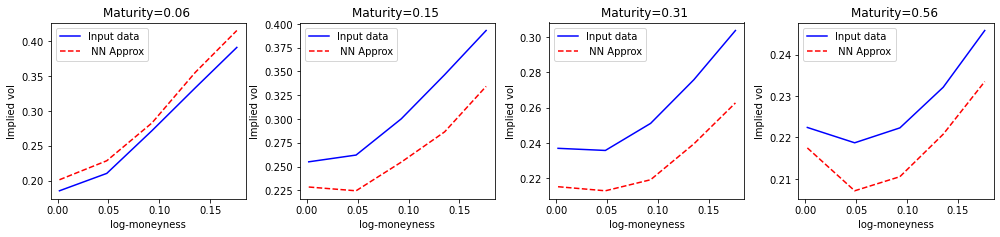

[0.6031 1.1651 0.7776 0.829  0.0026 0.1204]


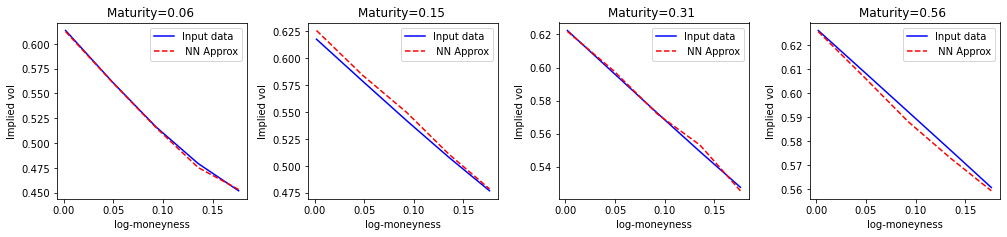

In [166]:
# S0=100.
S0 = 5.24
import time
for i in range(20):
    sample_ind = 5*i
    X_sample = x_test_transform[sample_ind]
    y_sample = y_test[sample_ind]
    print(X_test[sample_ind])

    prediction=scale.inverse_transform(modelGEN.predict(X_sample.reshape(1,6))[0])
    plt.figure(1,figsize=(14,6))
    for i in range(maturities_dim):
        plt.subplot(2,4,i+1)

        plt.plot(np.log(strikes/S0),y_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
        plt.plot(np.log(strikes/S0),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label=" NN Approx")


        plt.title("Maturity=%1.2f "%maturities[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    plt.tight_layout()
    plt.show()
#     time.sleep(5)
    

# Use gradient methods for optimisation

In [216]:
def CostFunc(x,sample_ind):
    return np.sum(np.power((NeuralNetwork(x)-y_test_transform[sample_ind]),2))
def Jacobian(x,sample_ind):
    return 2*np.sum((NeuralNetwork(x)-y_test_transform[sample_ind])*NeuralNetworkGradient(x),axis=1)
#Cost Function for Levenberg Marquardt
def CostFuncLS(x,sample_ind):
    return (NeuralNetwork(x)-y_test_transform[sample_ind])

def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T

In [213]:
len(X_test), X_test.shape
# X_test[:10]
lb
bounds1 = tuple((0, 1) for i in range(6))
bounds2 = ([0]*6, [1]*6)
bounds2
def fun_rosenbrock(x):
    return np.array([10 * (x[1] - x[0]**2), (1 - x[0])])
from scipy.optimize import least_squares
least_squares(fun_rosenbrock, [2,2], method='lm').x


array([1., 1.])

In [225]:
import time

Approx=[]
Timing = []

solutions=np.zeros([2,6])
init=[0.5]*6
times = np.zeros(2)
for i in range(len(X_test)):
    disp=str(i+1)+"/" + str(len(X_test))
    print (disp, end="\r")
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='SLSQP', jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[0,:]=scale_mm.inverse_transform(I.x.reshape(1, 6)).reshape(6,)
    times[0]=end-start
    
    #Levenberg-Marquardt
    start= time.time()
    I=scipy.optimize.least_squares(CostFuncLS, init, JacobianLS, method='lm', args=(i,),gtol=1E-10)
    end= time.time()
#     print(I.x.shape)
    solutions[1, :]=scale_mm.inverse_transform(I.x.reshape(1, 6)).reshape(6,)
    times[1] = end-start
    
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))
    
print("time spent: %ss"%np.round(np.sum(Timing, axis=0), 6))
# print("solution: ", np.round(np.mean(Approx, axis=0), 6))

time spent: [10.506336  1.951333]s


In [226]:
Approx[1]


array([[ 5.88804664e-01,  1.59548849e-01,  1.10768528e+00,
         5.94554563e-01, -5.63473645e-04,  1.78128255e-01],
       [ 5.77478886e-01,  5.55854944e-01,  3.49127740e-01,
         8.89742726e-01,  2.26388352e-03,  1.36859077e-01]])

### Prediction on market data

In [235]:
def CostFunc(x, sample_ind):
    return np.sum(np.power((NeuralNetwork(x)-market_iv[sample_ind]).reshape(1,20),2))
def Jacobian(x, sample_ind):
    return 2*np.sum((NeuralNetwork(x)-market_iv[sample_ind])*NeuralNetworkGradient(x),axis=1)
def CostFuncLS(x,sample_ind):
    return (NeuralNetwork(x)-market_iv[sample_ind])
def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T

In [242]:
market_iv = scale.transform(np.loadtxt('market_implied_vols.txt'))
print(len(market_iv))
result1 = []
result2 = []
for i in range(len(market_iv)):
    I=scipy.optimize.minimize(CostFunc,x0=init,method='SLSQP', jac=Jacobian, bounds=bounds1, args=(i), tol=1E-10,options={"maxiter":5000})
    result1.append(scale_mm.inverse_transform(I.x.reshape(1, 6)).reshape(6,))
    I=scipy.optimize.least_squares(CostFuncLS, init, JacobianLS, bounds=bounds2, args=(i,),gtol=1E-10)
    result2.append(scale_mm.inverse_transform(I.x.reshape(1,6)).reshape(6,))

288


In [243]:
np.mean(result1, axis=0), np.mean(result2, axis=0)

(array([5.05000000e-01, 2.00000000e+00, 1.16176811e-01, 1.36443154e-01,
        1.00000000e-04, 2.99900000e-01]),
 array([5.88148790e-01, 1.42207387e+00, 6.51764601e-01, 1.14732397e-01,
        1.00000000e-04, 1.56488271e-01]))

# Save the Lavenberg-Marquardt Optimal parameters

In [228]:
LMParameters=np.array([Approx[i][1] for i in range(len(Approx))])
np.savetxt("NNParametersQuadraticRoughHeston.txt",LMParameters)
LMParameters = np.loadtxt("NNParametersQuadraticRoughHeston.txt")
LMParameters.shape
np.mean(LMParameters, axis=0)
# Approx[0][0], Approx[0][1]

array([0.59469613, 0.7918069 , 0.55662331, 0.69224689, 0.00304469,
       0.11796796])

# Calibration Errors with Levenberg-Marquardt

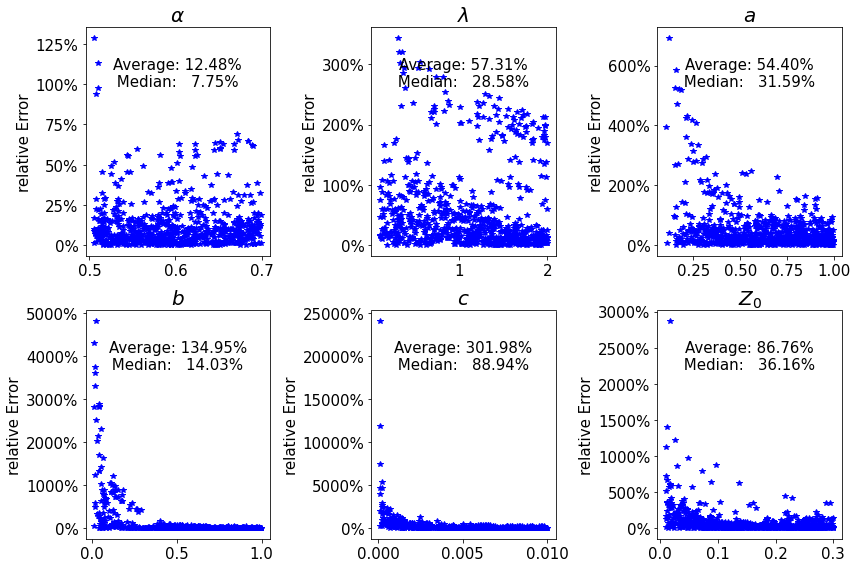

In [229]:
titles=["$\\alpha$","$\\lambda$","$a$","$b$", "$c$","$Z_0$"]
average=np.zeros([6,len(X_test)])
fig=plt.figure(figsize=(12,8))
for u in range(6):
    ax=plt.subplot(2,3,u+1)
    x=X_test[:len(X_test),u]
#     print(abs(LMParameters[:1800,u]))
#     print(100*np.abs(LMParameters[:1800,u]))
    plt.plot(x,100*np.abs(LMParameters[:len(X_test),u]-x)/np.abs(x),'b*')
    average[u,:]=np.abs(LMParameters[:len(X_test),u]-x)/np.abs(x)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()

# plt.savefig('HestonParameterRelativeErrors.png', dpi=300)
plt.show()

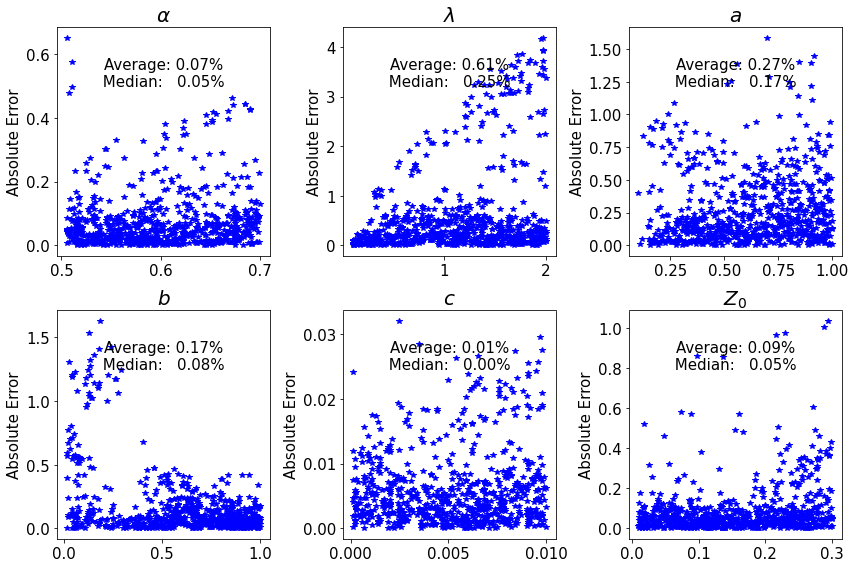

In [230]:
titles=["$\\alpha$","$\\lambda$","$a$","$b$", "$c$","$Z_0$"]
average=np.zeros([6,len(X_test)])
fig=plt.figure(figsize=(12,8))
for u in range(6):
    ax=plt.subplot(2,3,u+1)
    y=X_test[:len(X_test),u]
    plt.plot(y,np.abs(LMParameters[:len(X_test),u]-y),'b*')
    average[u,:]=np.abs(LMParameters[:len(X_test),u]-y)
    
    plt.title(titles[u],fontsize=20)
    plt.ylabel('Absolute Error',fontsize=15)
    #plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(average[u,:]),np.quantile(average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)
plt.tight_layout()

# plt.savefig('HestonParameterAbsoluteErrors.png', dpi=300)
plt.show()